# Assignment 3

*Done by Diego Plumed*

## Itroduction

In this notebook, we will be analysing COVID-19 data making use of two different RNN methods: LSTM (Long Short-Term Memory) and its more complex version, CNN-LSTM. In particular, we will be analysing COVID-19 data from Spain for the period from 17/11/2020 to 17/12/2020.


###  Import Packages and Download Datasets

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
# !python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
# !unzip -q COVIDTimeSeries.zip

## LSTM 

##  Data Pre-Processing

After transforming the time series data into supervised learning data, we will divide the data into training, validation, and test sets. After that, we will perform data scaling based on the statistics of the training data. 

In [ ]:
#Load the cumulative COVID-19 cases for Spaim.
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Spain']
korea = confirmed[confirmed['Country/Region']=='Spain'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

# Dividing the dataset into traning, validation, and test sets.
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax scaling.
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor transformation.
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/88421647.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  korea.index = pd.to_datetime(korea.index)


In [3]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


##  Defining the LSTM Model

We build the LSTM model. `CovidPredictor` consists of basic attributes, constructor for layer initialization, the `reset_hidden_state` function for resetting weights, and the `forward` function for prediction.

In [7]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

##  Training

We will define the `train_model` function in order to train `CovidPredictor`. The inputs are from the training and validation sets: `num_epochs` indicates the number of epoch times; `verbose` here indicates how often each `epoch` is printed; and `patience` is used to stop training if validation loss ceases to decrease after `patience` number of epochs. In PyTorch, `hidden_state` is preserved throughout the training, so `hidden_state` needs to be reset every sequence in order not to be affected from the previous `hidden_state`.


All in all, the function arquitecture is the following:

	1.	Loops over epochs
	2.	For each sequence:
		•	Resets hidden state (important for LSTMs)
		•	Performs forward pass
		•	Computes L1 loss
		•	Backpropagates
	3.	Computes validation loss (if provided)
	4.	Implements simple early stopping
	5.	Returns:
		•	trained model
		•	training loss history
		•	validation loss hist

In [5]:
# this is an improved model, skip this model for the moment and run the rest of the code

import torch
from copy import deepcopy

def train_model_(
    model,
    train_data,
    train_labels,
    val_data=None,
    val_labels=None,
    num_epochs=100,
    verbose=10,
    patience=10,
    lr=1e-3,
    restore_best=True
):
    """
    Train a sequence model with optional validation and modern early stopping.

    Early stopping logic:
      - Keep track of the best validation loss (lowest)
      - If no improvement for `patience` consecutive epochs -> stop
      - Optionally restore best model weights

    Assumes:
      - model has reset_hidden_state()
      - model(seq) returns a prediction tensor
      - regression loss (L1Loss) with scalar targets
    """

    loss_fn = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    train_hist = []
    val_hist = []

    best_val = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # -------------------------
        # Training loop
        # -------------------------
        for idx, seq in enumerate(train_data):
            model.reset_hidden_state()

            # Ensure seq is tensor float
            if not torch.is_tensor(seq):
                seq = torch.tensor(seq)
            seq = seq.float()

            # Ensure shape: (1, seq_len, n_features)
            if seq.dim() == 1:                  # (seq_len,)
                seq = seq.unsqueeze(0).unsqueeze(-1)  # -> (1, seq_len, 1)
            elif seq.dim() == 2:                # (seq_len, n_features)
                seq = seq.unsqueeze(0)          # -> (1, seq_len, n_features)

            y_true = train_labels[idx]
            if not torch.is_tensor(y_true):
                y_true = torch.tensor(y_true)
            y_true = y_true.float()

            y_pred = model(seq).squeeze()
            loss = loss_fn(y_pred, y_true)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_data)
        train_hist.append(train_loss)

        # -------------------------
        # Validation loop
        # -------------------------
        if val_data is not None and val_labels is not None:
            model.eval()
            val_loss_sum = 0.0

            with torch.no_grad():
                for v_idx, v_seq in enumerate(val_data):
                    model.reset_hidden_state()

                    if not torch.is_tensor(v_seq):
                        v_seq = torch.tensor(v_seq)
                    v_seq = v_seq.float()

                    if v_seq.dim() == 1:
                        v_seq = v_seq.unsqueeze(0).unsqueeze(-1)
                    elif v_seq.dim() == 2:
                        v_seq = v_seq.unsqueeze(0)

                    v_true = val_labels[v_idx]
                    if not torch.is_tensor(v_true):
                        v_true = torch.tensor(v_true)
                    v_true = v_true.float()

                    v_pred = model(v_seq).squeeze()
                    v_loss = loss_fn(v_pred, v_true)

                    val_loss_sum += v_loss.item()

            val_loss = val_loss_sum / len(val_data)
            val_hist.append(val_loss)

            # Print progress
            if epoch % verbose == 0:
                print(f"Epoch {epoch} | train L1: {train_loss:.6f} | val L1: {val_loss:.6f}")

            # -------------------------
            # Early stopping logic
            # -------------------------
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                epochs_no_improve = 0
                if restore_best:
                    best_state = deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch}. Best val L1 = {best_val:.6f}")
                break

        else:
            if epoch % verbose == 0:
                print(f"Epoch {epoch} | train L1: {train_loss:.6f}")

    # Restore best weights if requested and available
    if restore_best and best_state is not None:
        model.load_state_dict(best_state)

    return model, train_hist, val_hist

In [6]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model_(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

/opt/miniconda3/envs/dl/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 | train L1: 0.085036 | val L1: 0.359933
Epoch 10 | train L1: 0.068195 | val L1: 0.334440
Epoch 20 | train L1: 0.066919 | val L1: 0.332438
Epoch 30 | train L1: 0.066005 | val L1: 0.331768
Epoch 40 | train L1: 0.065287 | val L1: 0.331395
Epoch 50 | train L1: 0.064191 | val L1: 0.331461
Epoch 60 | train L1: 0.064558 | val L1: 0.333263
Epoch 70 | train L1: 0.062848 | val L1: 0.331023

Early stopping at epoch 73. Best val L1 = 0.330323


Let's visualize the loss values saved in `train_hist` and `val_hist`.

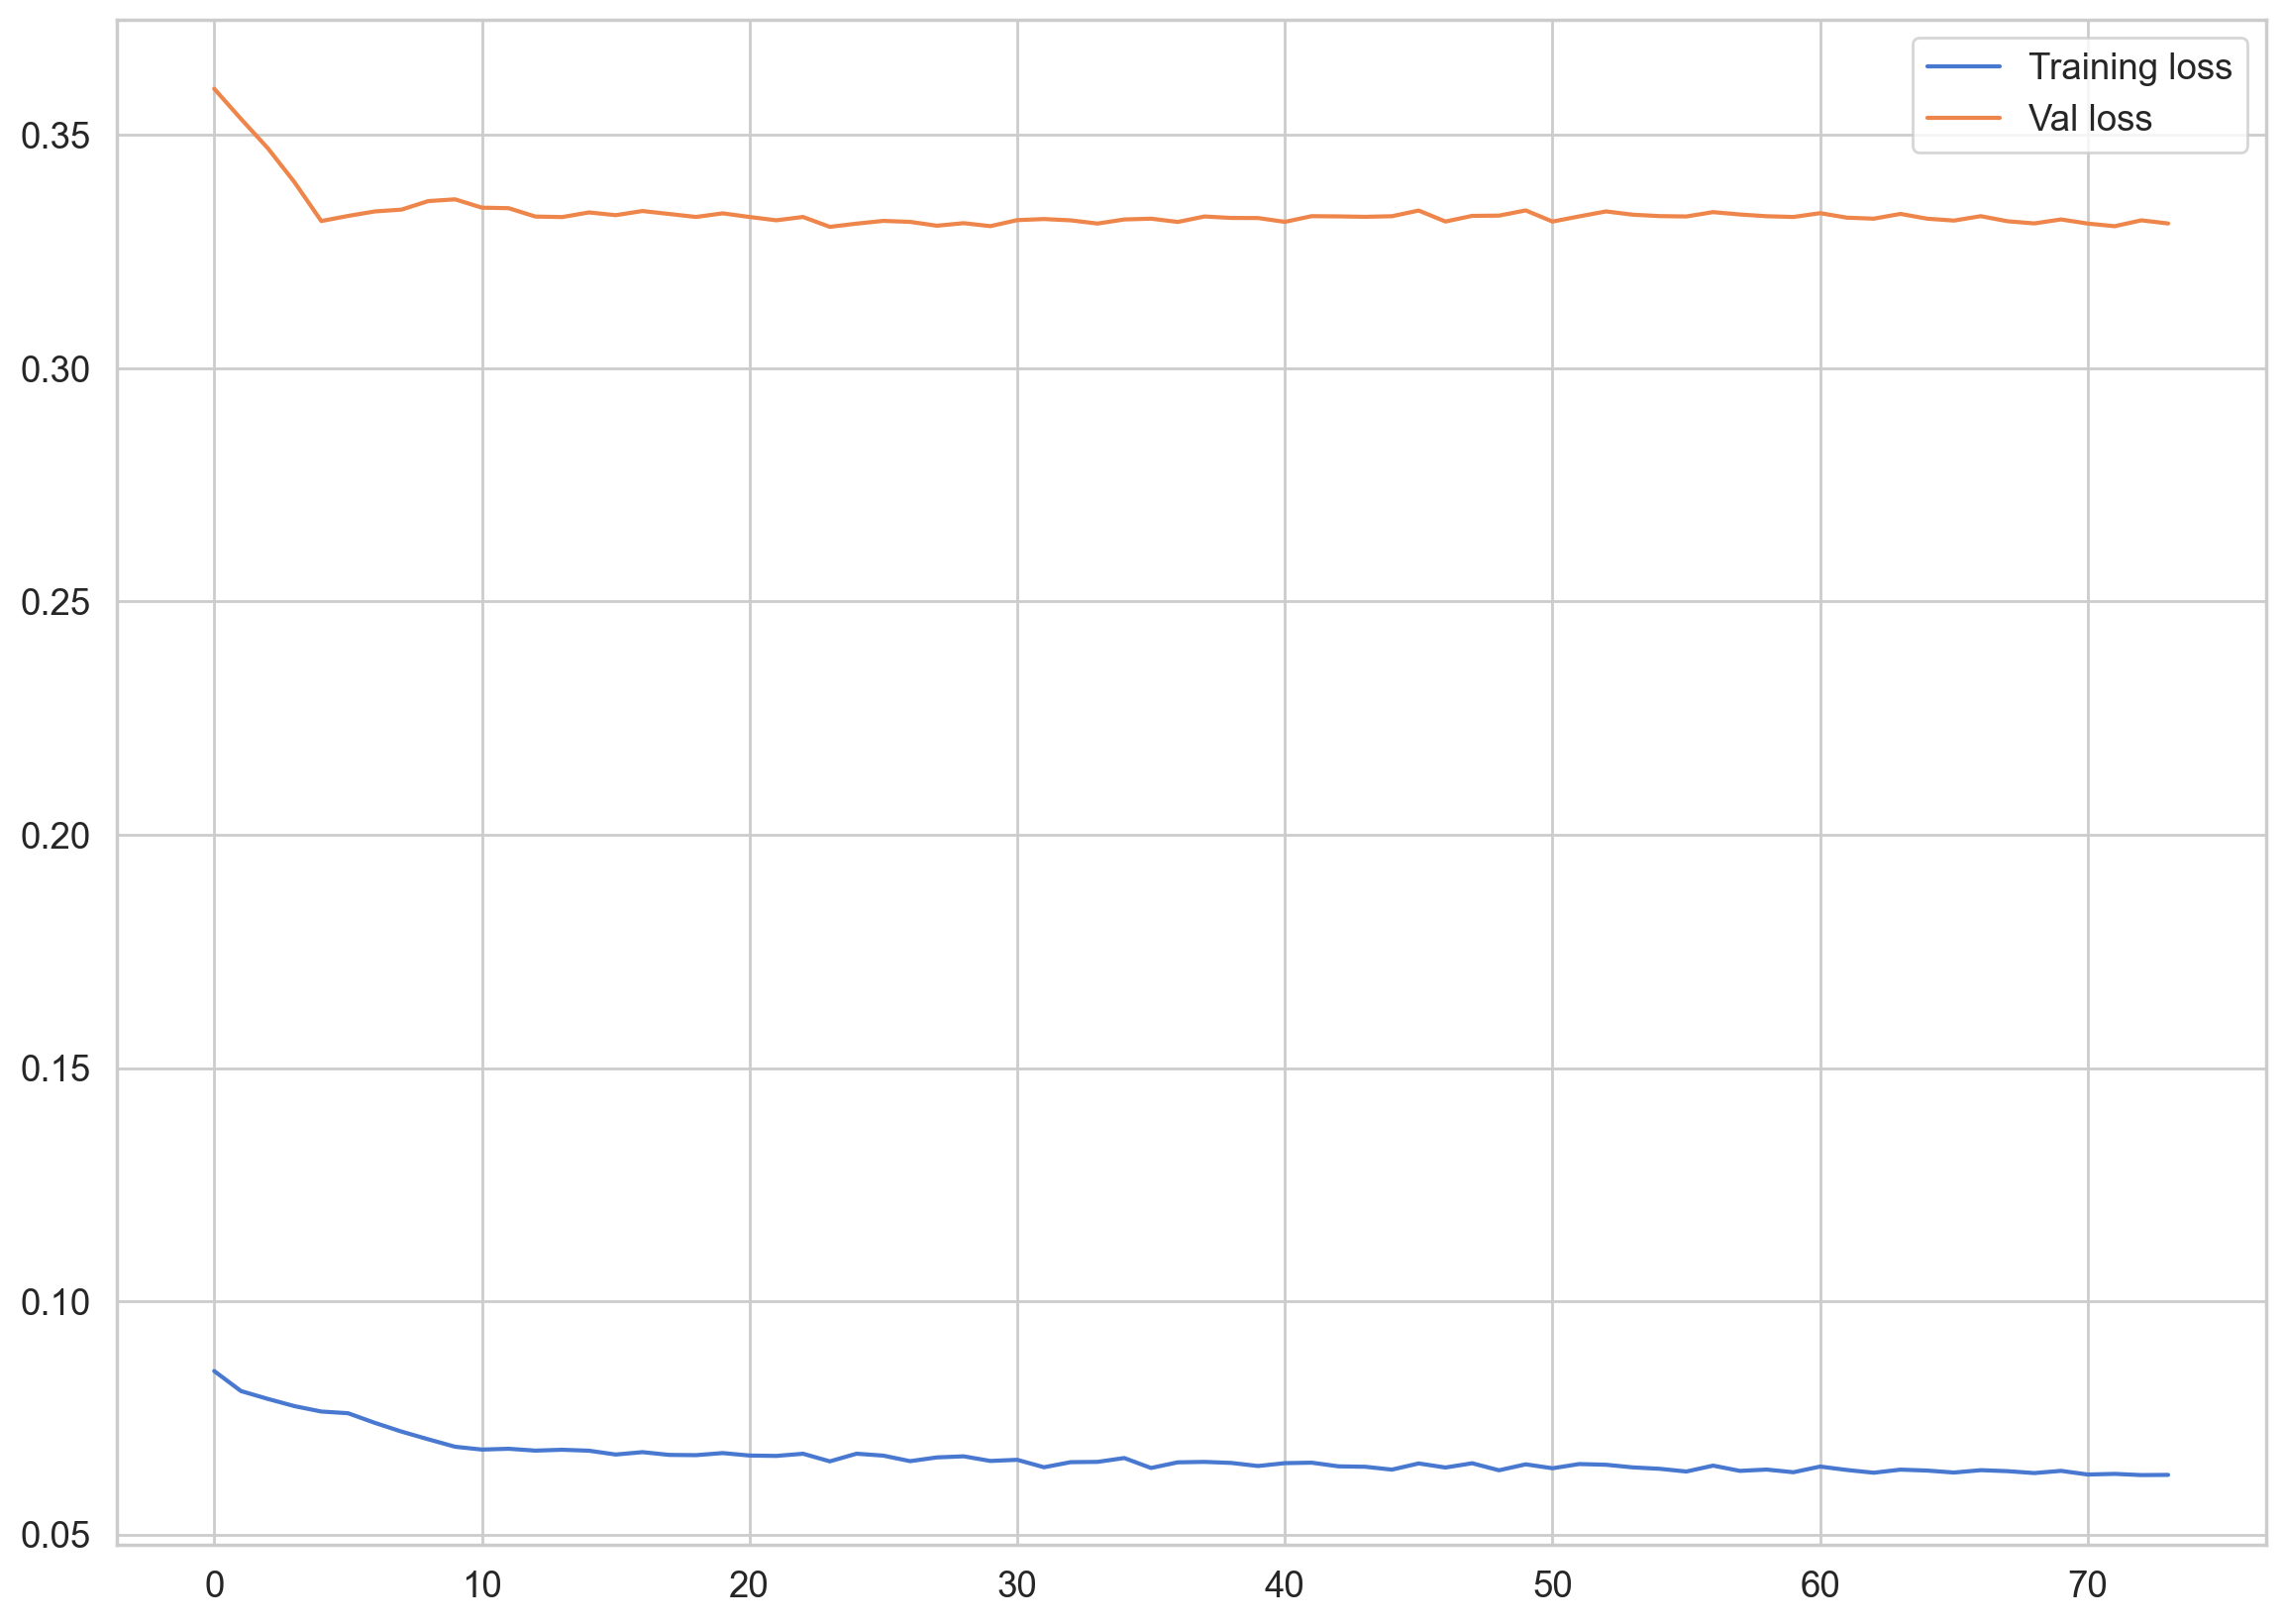

In [8]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

**Note**: We observe that the model fits the training data so quick that its generalisiation to the test data barly improves throught the training. This is a clear sign of overfitting.

###

##  Prediction

###  One-Step Prediction

Firstly, we will view the performance of the model we built earlier by performing a `One-Step` prediction. We will predict on the test dataset we built. Whenever new sequence values are input for a prediction, we need to reset `hidden_state` to avoid reflecting the previous `hidden_state` calculated from the previous sequence. Using the `torch.unsqueeze` function, we need to extend the dimensions of the input data to a three-dimensional shape that the model expects. In addition, we will extract only the scalar value from the `y_test_pred` to be added to the <code>preds</code> list.

In [9]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

We will compare the predicted values that the model predicted to the true values. True values are saved in `y_test`, where the data has already been through data scaling. We will utilize the formula below in order to transform the values back into the original scale. The formula below was tweaked based on the formula used for MinMax scaling in the preprocessing chunk. 

> $x = x_{scaled} * (x_{max} - x_{min}) + x_{min}$

In the data, $x_{min}$ was 0. Therefore, all we need is to multiply $x_{max}$ times the scaled value to restore it into original scale. 

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/1166591655.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')


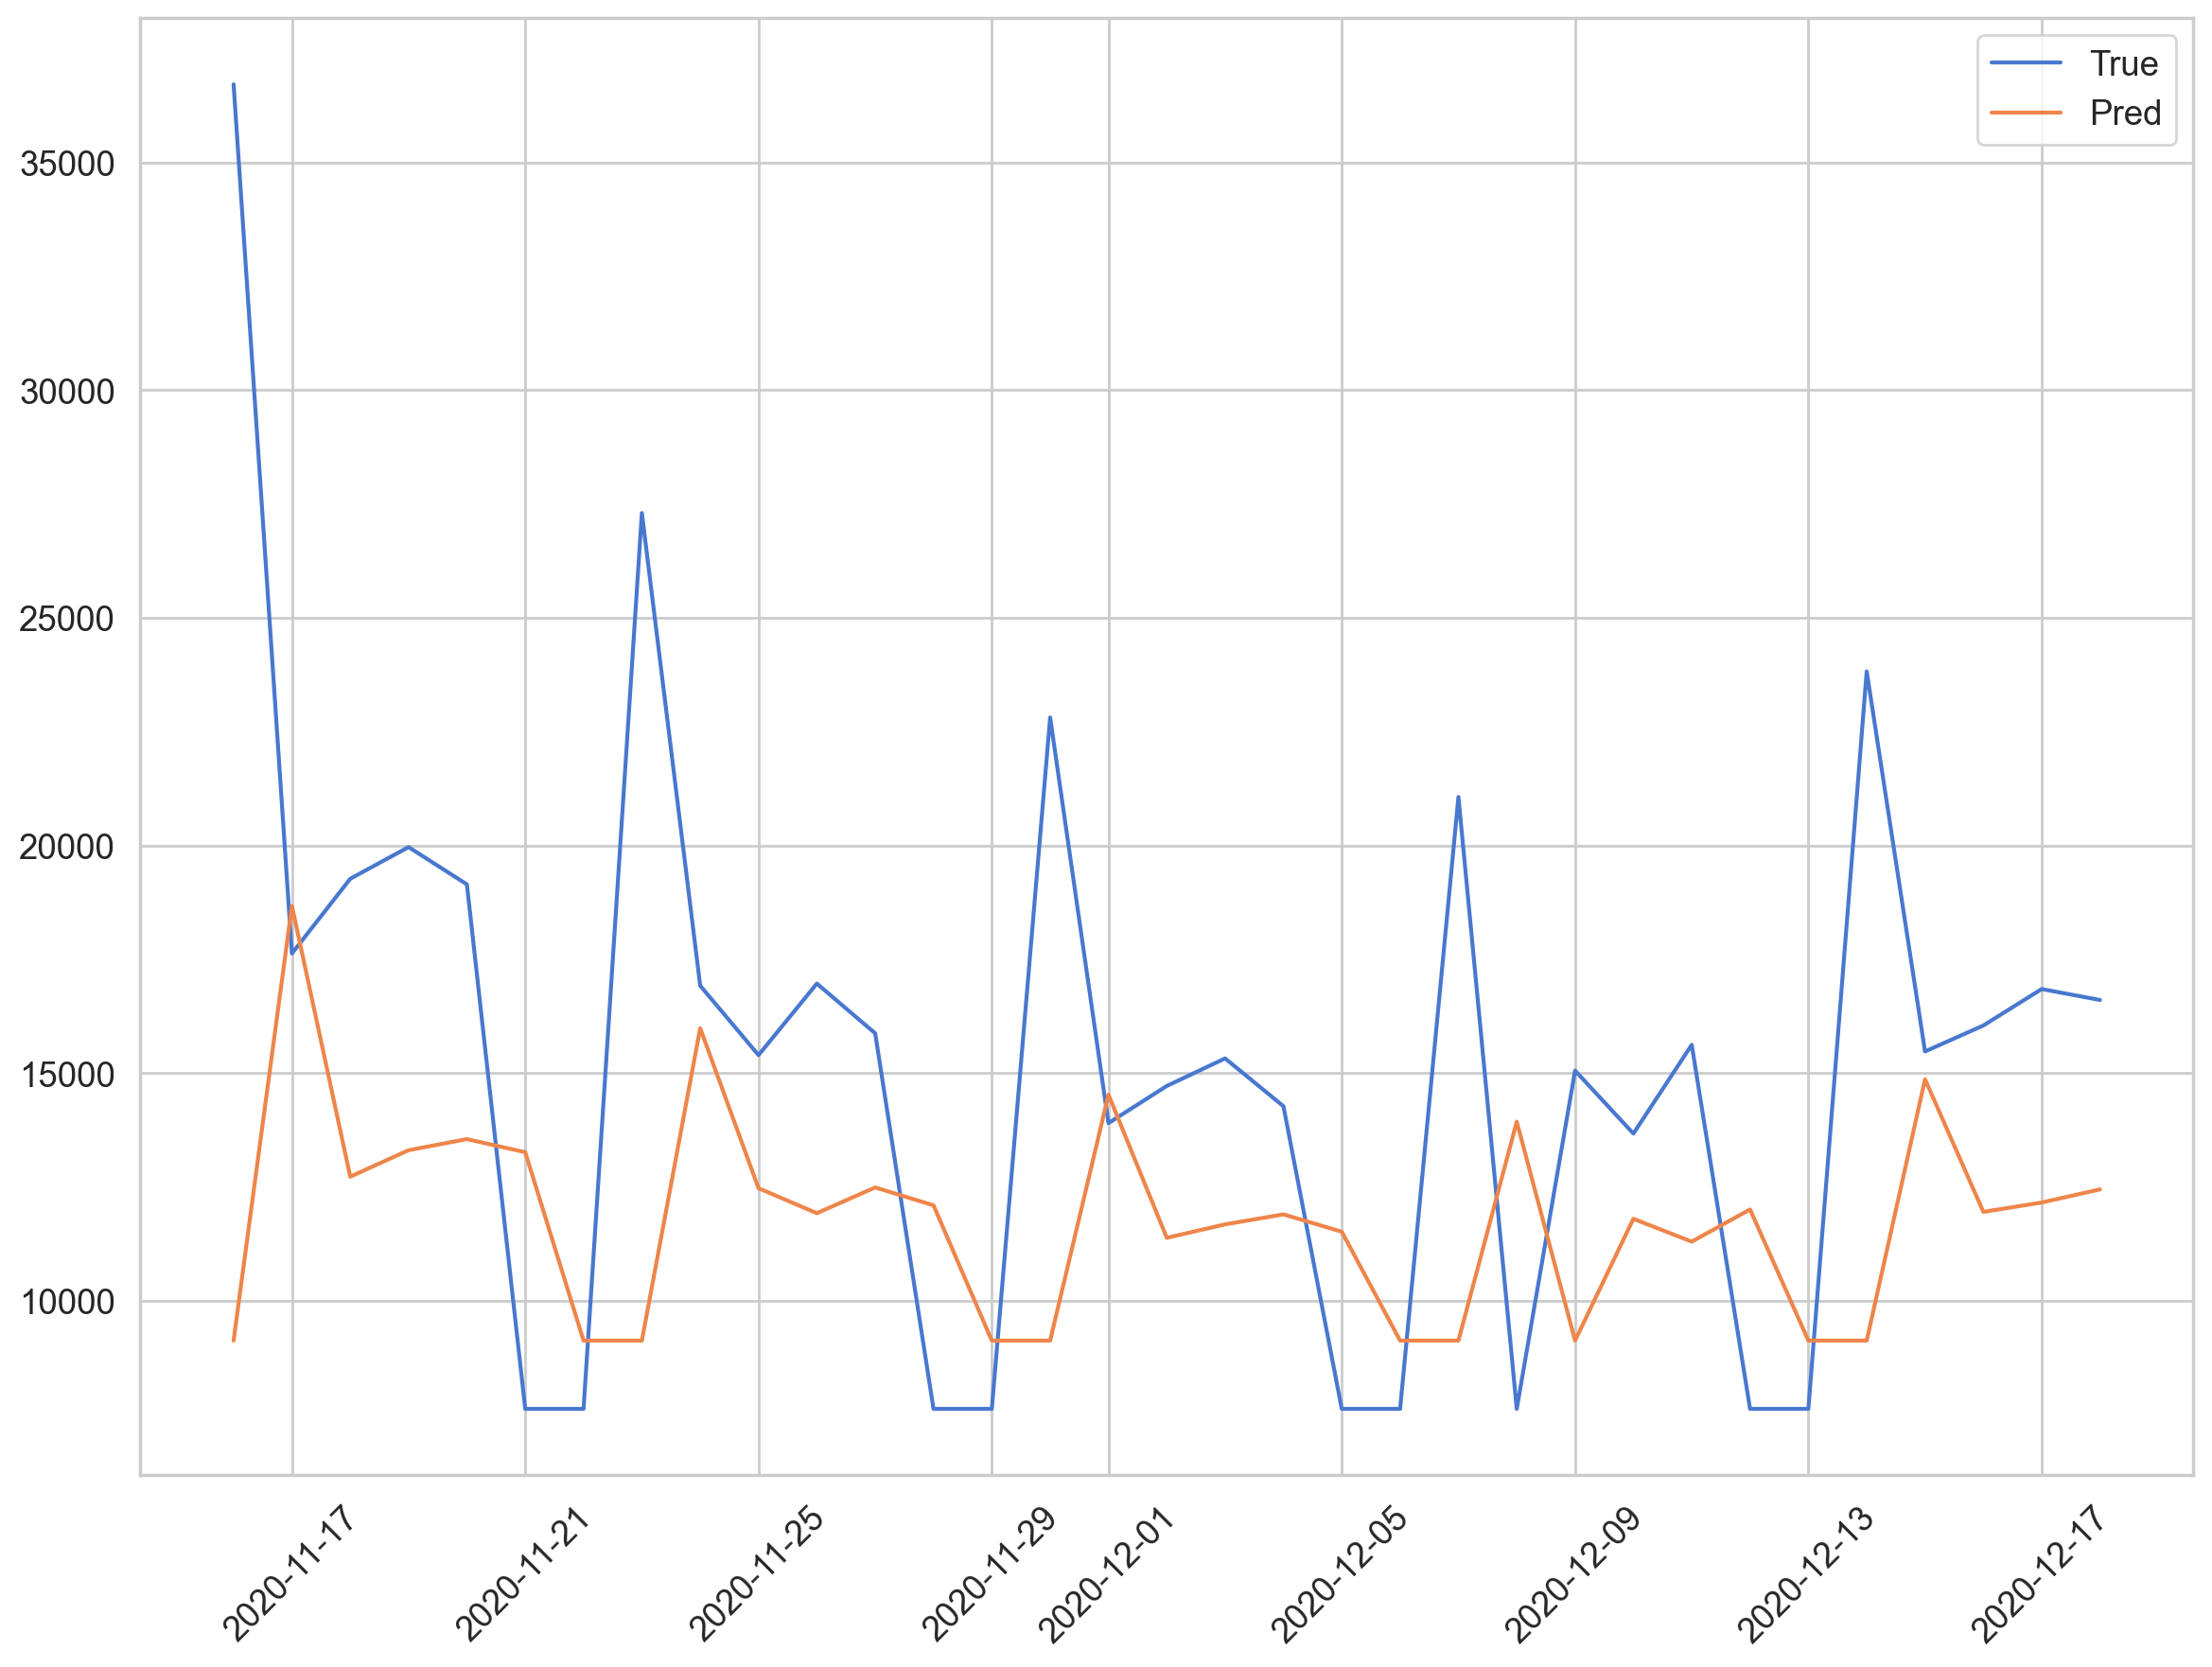

In [10]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

The blue line shows the true values, and the orange line reveals the predicted values.

We observe that, although the model captures the hilly trend of the data, it is not precise when predicting the spiky nature of the graph, especially when such spikes represent an abrupt increase. Thus, I would not recommend the use of this model for this particular dataset, since it could result in overconfidence when estimating the disease’s impact and, therefore, lead to logistical problems in hospitals and sudden fear among the population.


We will calculate the MAE in order to find the mean absolute error of the predicted values. 

In [11]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [12]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/3206875136.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


np.float64(6022.5459587506275)

We can see that the predicted values show an average difference of around 6,000 cases compared to the true values. It would be more precise if we used population movement and statistical data, and so on, in addition to the data on previous COVID-19 cases. This leads us to the following step.


###  Multi-Step Prediction

We will perform a `Multi-Step` prediction, iteratively using the `One-Step` prediction model. We will predict future values by including the predicted value generated through the first sample of the test data into the input sequence, and then repeating the predictions by including the new predicted values into the input sequence. 

In [13]:
# Disable gradient tracking (important for inference / testing)
with torch.no_grad():

    # Take the first test sequence
    # Expected shape: (1, seq_length, 1)
    test_seq = X_test[:1]

    # List to store predictions
    preds = []

    # Perform recursive multi-step forecasting
    for _ in range(len(X_test)):

        # Reset hidden state for RNN/LSTM
        # Important: prevents hidden state accumulation across predictions
        model.reset_hidden_state()

        # Forward pass: predict next time step
        y_test_pred = model(test_seq)

        # Convert model output tensor to scalar value
        # flatten() ensures shape compatibility
        # item() converts tensor to Python float
        pred = torch.flatten(y_test_pred).item()

        # Store prediction
        preds.append(pred)

        # -------------------------------
        # Update the input sequence
        # -------------------------------

        # Convert tensor to NumPy array and flatten
        # Shape becomes: (seq_length,)
        new_seq = test_seq.numpy().flatten()

        # Append predicted value to end of sequence
        # Sequence becomes length (seq_length + 1)
        new_seq = np.append(new_seq, [pred])

        # Remove the oldest value (first element)
        # This keeps sequence length constant
        # Implements sliding window mechanism
        new_seq = new_seq[1:]

        # Convert updated sequence back to tensor
        # Reshape to (1, seq_length, 1) for next model input
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

Because predictions are fed back as inputs:

	- •	Small prediction errors propagate forward
	- •	Multi-step forecasts may drift over time
    
As mentioned above, as the prediction period gets longer, the accuracy of this method begins to wane. Let us visualize the comparison between the predicted and true values below.

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/1166591655.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')


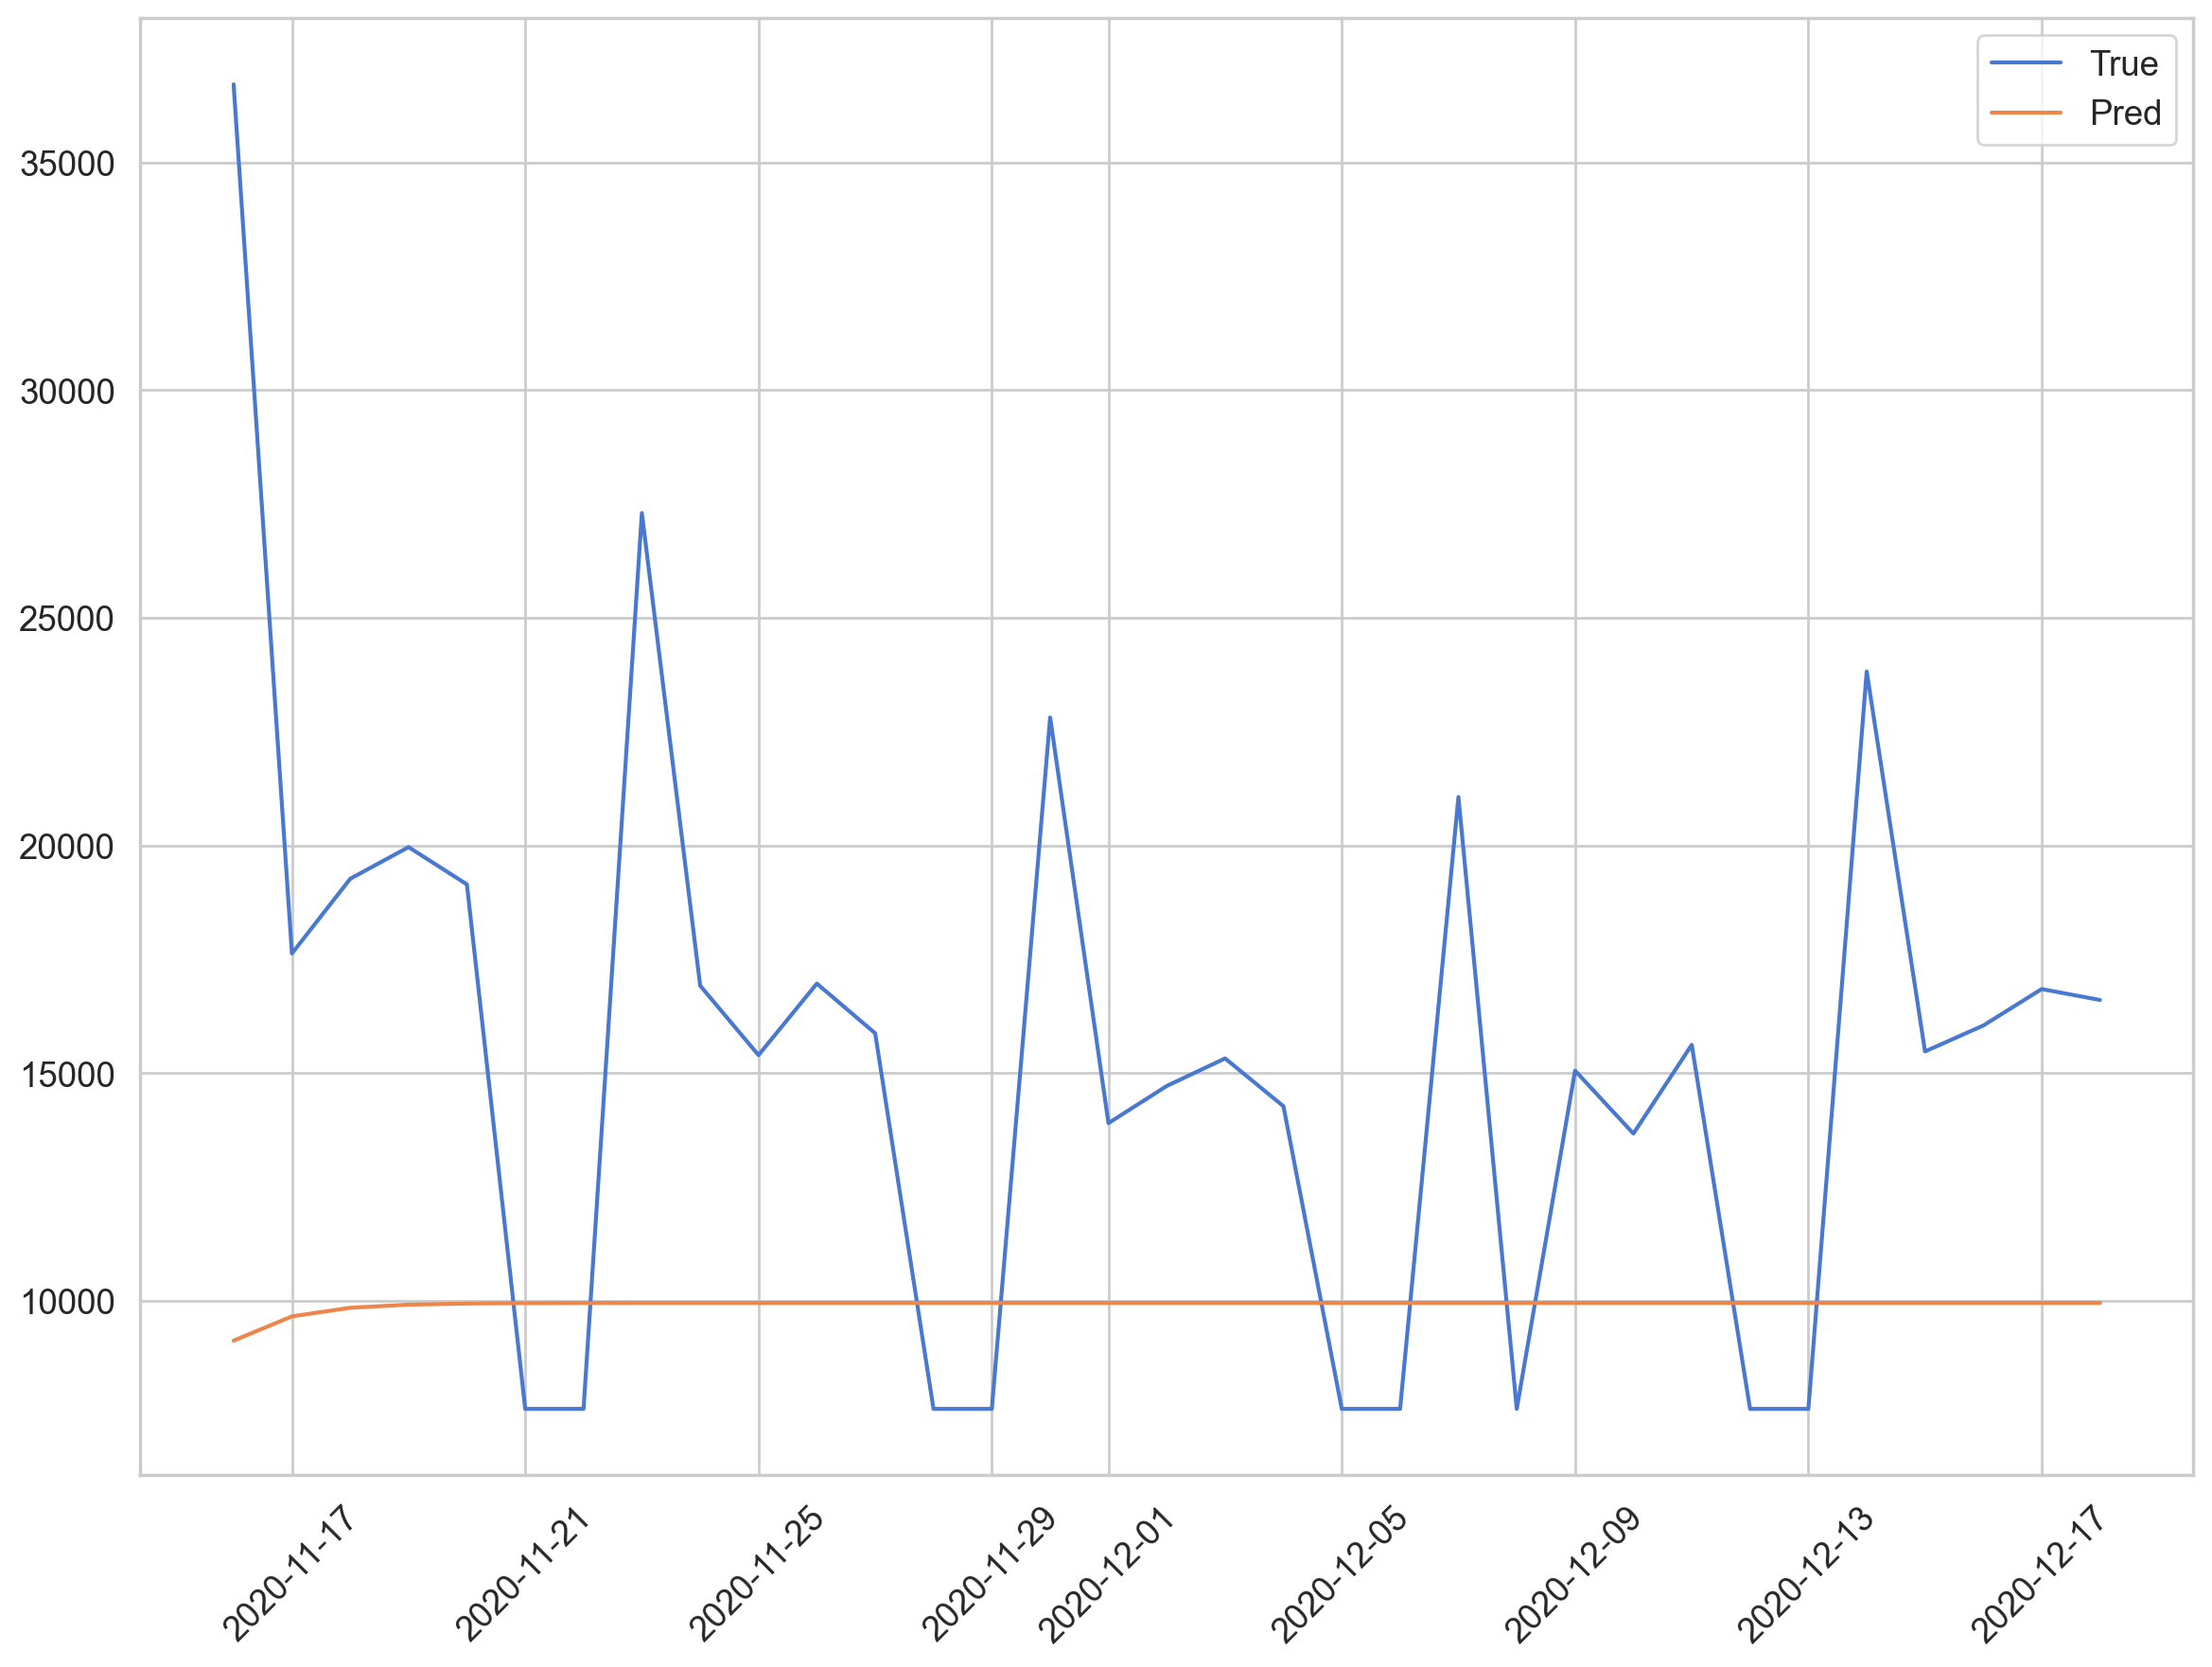

In [14]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

Indeed, the generalisation is very poor.

###

###

Let us repeat the process supporting the model in a more complex architecture.

#  CNN-LSTM

We first visualise the daily COVID-19 cases in Spain.

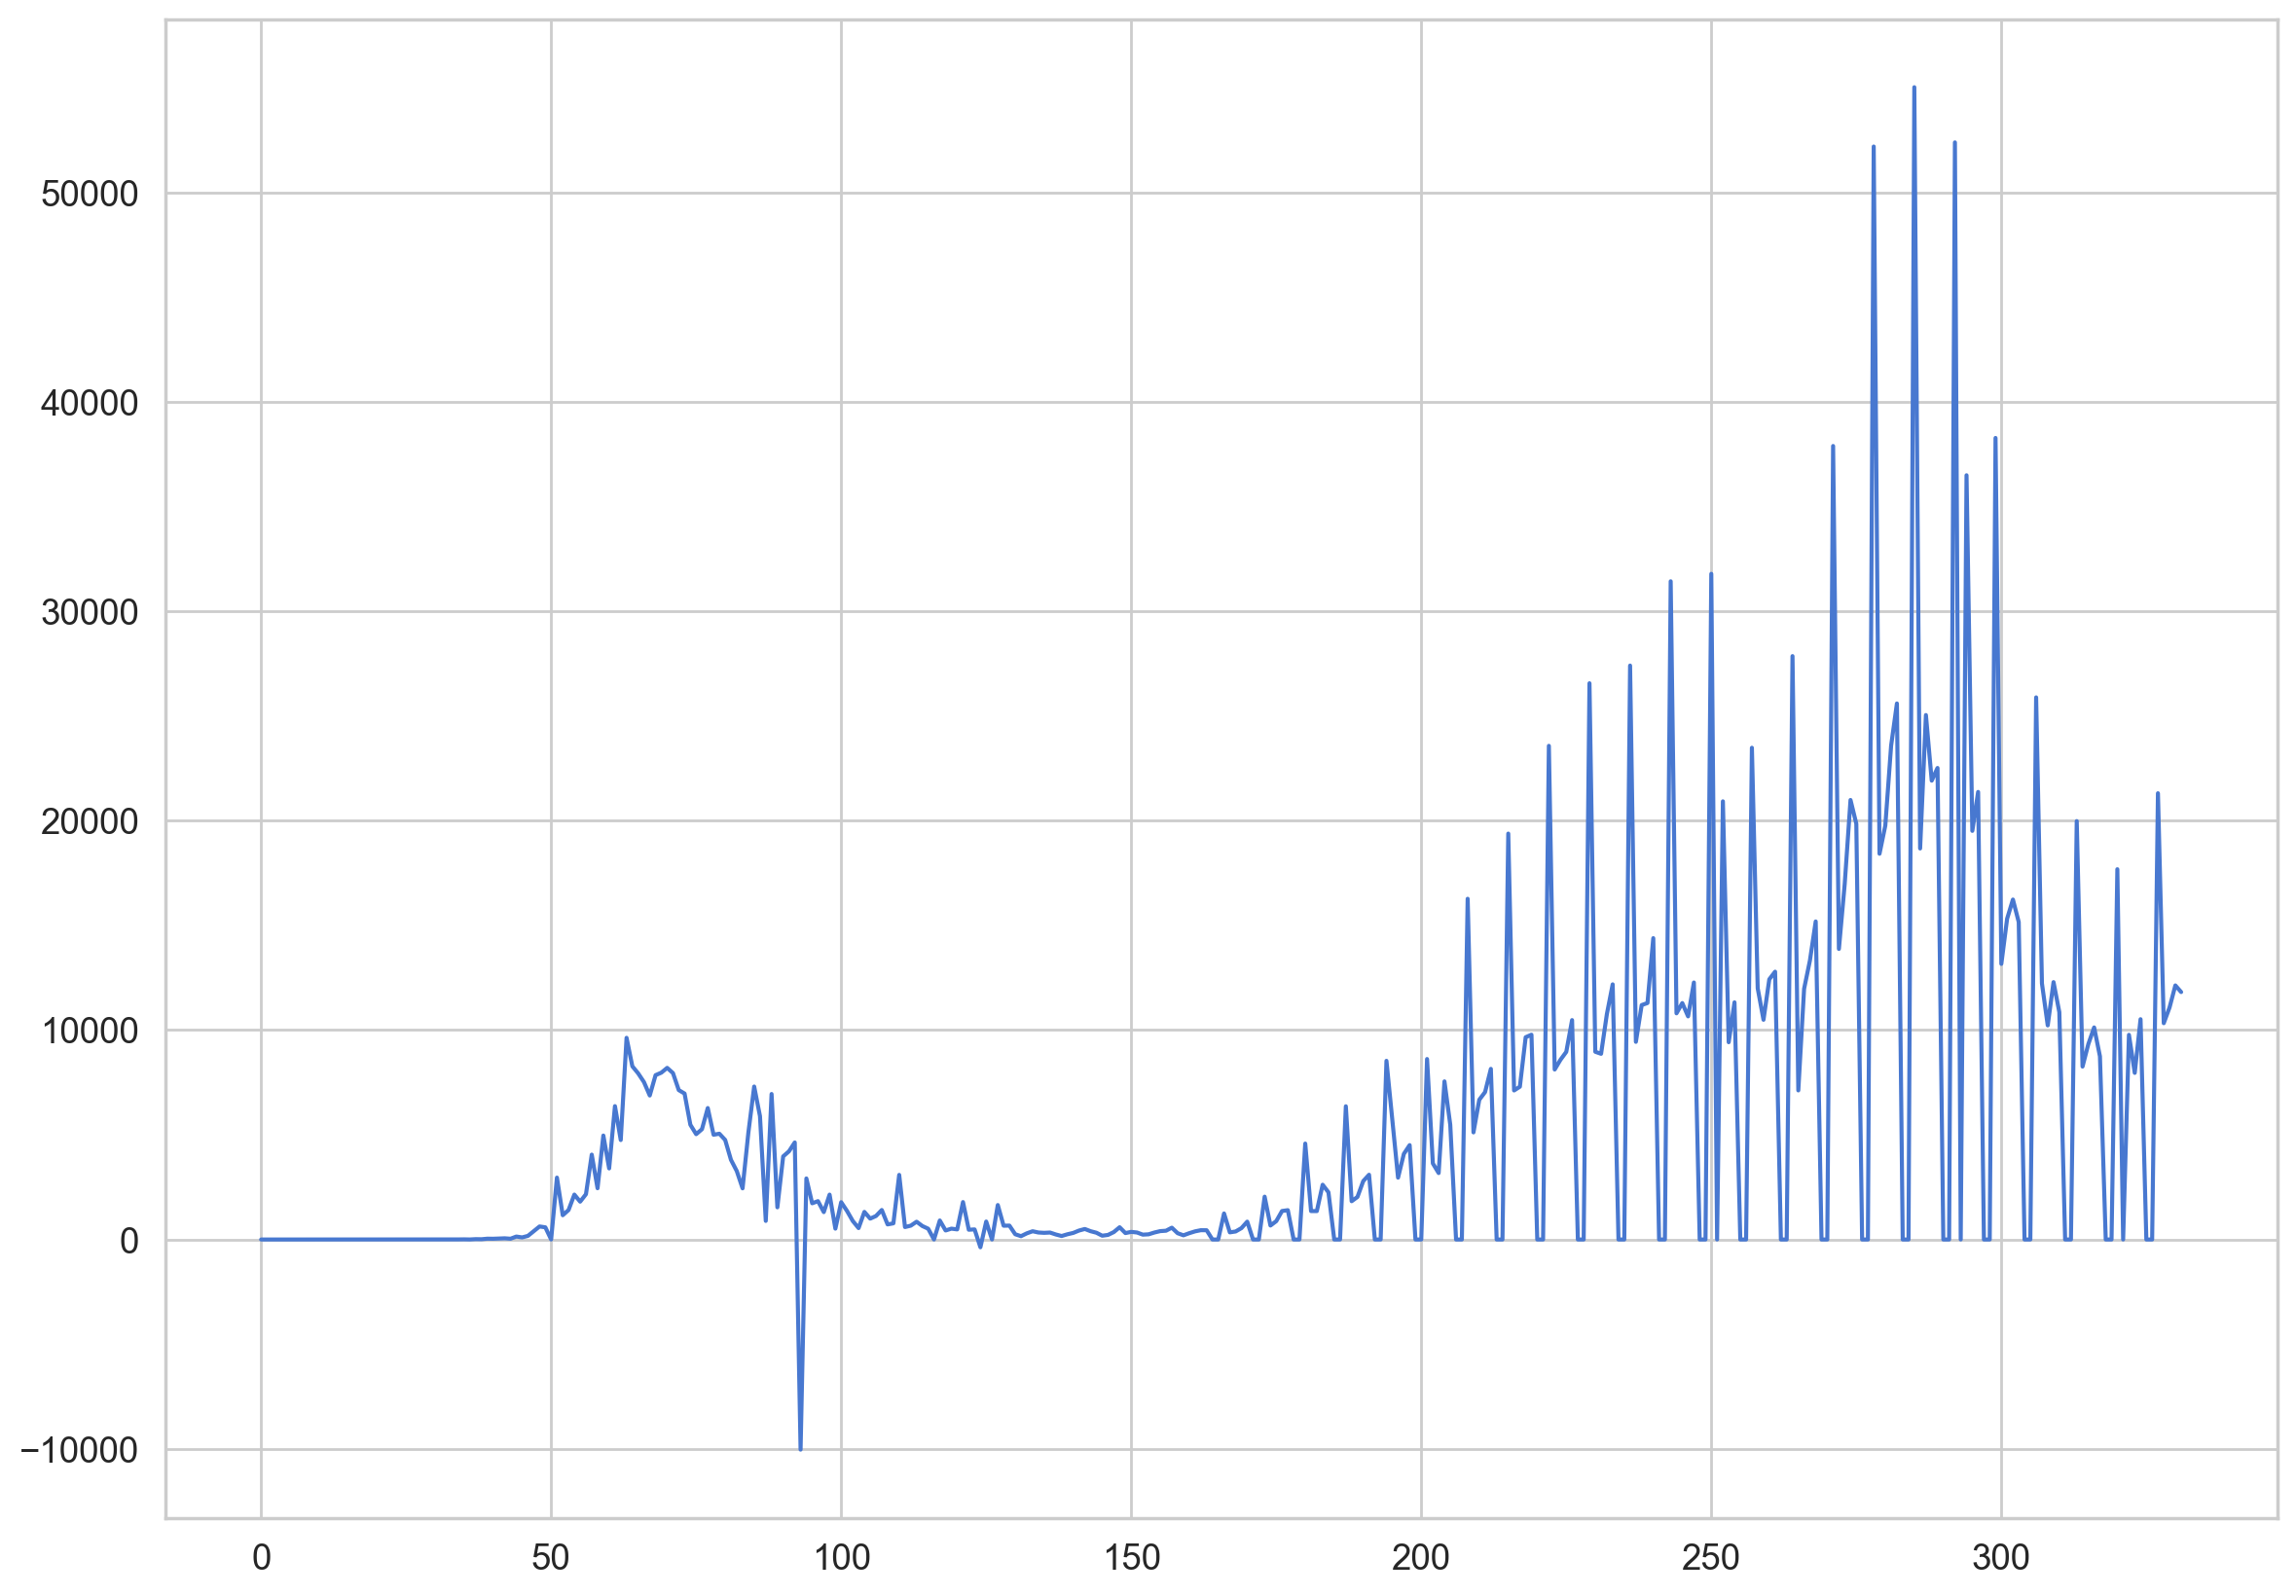

In [15]:
plt.plot(daily_cases.values)

As we knew, the data behaves spikely.

### Build the CNN-LSTM Model

We will build the CNN-LSTM model. The biggest difference from the LSTM model we built is that we are add furthermore a 1D CNN layer. When viewing the code below, we can see that the 1D CNN layer was added to `CovidPredictor` through `nn.Conv1d`.

Is worth mentioning that the following code represents an improved version of the one porvided in Chapter 4, Lecture 8. The model enhancements are:

- Added dropout: To reduce overfitting.
- Additional ReLU and flexible number of conv. layers: To reduce patterns and generalise better.
- Add padding: To increase stability and processed data.

In [25]:
# ============================================================
# FULL WORKING PACKAGE: CovidPredictor (CNN+LSTM) + train_model
# ============================================================
# - Handles input shapes safely: (seq_len,) or (seq_len, n_features)
# - Converts to (batch=1, seq_len, n_features)
# - Works on CPU / CUDA / MPS
# - Proper modern early stopping (best val loss + patience counter)
# - Uses L1Loss (MAE) by default for regression
# ============================================================

import torch
import torch.nn as nn
from copy import deepcopy


# --------------------------
# Model: CNN + LSTM
# --------------------------
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers, conv_channels=32, dropout=0.2):
        super().__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.seq_len = seq_len

        # Conv1d expects (batch, channels=n_features, seq_len)
        # We keep channels the same (n_features -> n_features)
        self.c1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=conv_channels,
            kernel_size=2,
            stride=1,
            padding=1   # keeps sequence length constant
        )

        # Non-linearity after convolution
        self.relu = nn.ReLU()

        # LSTM expects (batch, seq_len, n_features) when batch_first=True
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )

        # Dropout before final layer
        self.dropout = nn.Dropout(dropout)

        # Final regression layer
        self.linear = nn.Linear(n_hidden, 1)

        # Placeholder for hidden state (h0, c0)
        self.hidden = None

    def reset_hidden_state(self, batch_size, device):
        """Create fresh hidden + cell state on the correct device."""
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        self.hidden = (h0, c0)

    def forward(self, sequences):
        """
        sequences: (batch, seq_len, n_features)
        returns:   (batch, 1)
        """
        batch_size = sequences.size(0)
        device = sequences.device

        # Ensure hidden exists and matches batch/device
        if (
            self.hidden is None
            or self.hidden[0].size(1) != batch_size
            or self.hidden[0].device != device
        ):
            self.reset_hidden_state(batch_size=batch_size, device=device)

        # Conv1d needs channels-first: (batch, n_features, seq_len)
        x = sequences.permute(0, 2, 1)

        # Apply convolution (reduces seq length by 1 when kernel_size=2, stride=1, no padding)
        x = self.c1(x)
        x = self.relu(x)    #Add ReLU


        # Back to LSTM format: (batch, seq_len_new, n_features)
        x = x.permute(0, 2, 1)

        # LSTM forward
        lstm_out, self.hidden = self.lstm(x, self.hidden)

        # Use last time step
        last_time_step = lstm_out[:, -1, :]  # (batch, n_hidden)

        # Add dropout
        x = self.dropout(last_time_step)

        # Linear head
        y_pred = self.linear(last_time_step)  # (batch, 1)
        return y_pred


# --------------------------
# Training function (modern early stopping)
# --------------------------
def train_model(
    model,
    train_data,
    train_labels,
    val_data=None,
    val_labels=None,
    num_epochs=100,
    verbose=10,
    patience=10,
    lr=1e-3,
    restore_best=True
):
    """
    Train model with:
      - L1Loss (MAE) regression
      - Adam optimizer
      - Optional validation
      - Modern early stopping based on best val loss

    train_data: iterable of sequences (each could be tensor/np array)
    train_labels: iterable of targets (scalar)
    """

    device = next(model.parameters()).device
    loss_fn = nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    train_hist = []
    val_hist = []

    best_val = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        # ----------------------
        # Training loop
        # ----------------------
        for idx, seq in enumerate(train_data):
            # Convert seq -> torch tensor on correct device
            if not torch.is_tensor(seq):
                seq = torch.tensor(seq)
            seq = seq.float().to(device)

            # Ensure shape is (1, seq_len, n_features)
            if seq.dim() == 1:  # (seq_len,)
                seq = seq.unsqueeze(0).unsqueeze(-1)     # -> (1, seq_len, 1)
            elif seq.dim() == 2:  # (seq_len, n_features)
                seq = seq.unsqueeze(0)                   # -> (1, seq_len, n_features)

            # Reset hidden per sequence (stateless training)
            model.reset_hidden_state(batch_size=seq.size(0), device=device)

            # Prepare label
            y_true = train_labels[idx]
            if not torch.is_tensor(y_true):
                y_true = torch.tensor(y_true)
            y_true = y_true.float().to(device)

            # Forward + loss
            y_pred = model(seq).squeeze()  # -> scalar
            loss = loss_fn(y_pred, y_true)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_data)
        train_hist.append(train_loss)

        # ----------------------
        # Validation loop
        # ----------------------
        if val_data is not None and val_labels is not None:
            model.eval()
            val_loss_sum = 0.0

            with torch.no_grad():
                for v_idx, v_seq in enumerate(val_data):
                    if not torch.is_tensor(v_seq):
                        v_seq = torch.tensor(v_seq)
                    v_seq = v_seq.float().to(device)

                    if v_seq.dim() == 1:
                        v_seq = v_seq.unsqueeze(0).unsqueeze(-1)
                    elif v_seq.dim() == 2:
                        v_seq = v_seq.unsqueeze(0)

                    model.reset_hidden_state(batch_size=v_seq.size(0), device=device)

                    v_true = val_labels[v_idx]
                    if not torch.is_tensor(v_true):
                        v_true = torch.tensor(v_true)
                    v_true = v_true.float().to(device)

                    v_pred = model(v_seq).squeeze()
                    v_loss = loss_fn(v_pred, v_true)
                    val_loss_sum += v_loss.item()

            val_loss = val_loss_sum / len(val_data)
            val_hist.append(val_loss)

            # Print progress
            if epoch % verbose == 0:
                print(f"Epoch {epoch} | train L1: {train_loss:.6f} | val L1: {val_loss:.6f}")

            # Early stopping check
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                epochs_no_improve = 0
                if restore_best:
                    best_state = deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch}. Best val L1 = {best_val:.6f}")
                break

        else:
            if epoch % verbose == 0:
                print(f"Epoch {epoch} | train L1: {train_loss:.6f}")

    # Restore best weights
    if restore_best and best_state is not None:
        model.load_state_dict(best_state)

    return model, train_hist, val_hist


# --------------------------
# Example usage (uncomment + adapt)
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = CovidPredictor(n_features=1, n_hidden=4, seq_len=seq_length, n_layers=1).to(device)

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

/opt/miniconda3/envs/dl/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 | train L1: 0.105738 | val L1: 0.321028
Epoch 10 | train L1: 0.070326 | val L1: 0.323167
Epoch 20 | train L1: 0.063326 | val L1: 0.322509
Epoch 30 | train L1: 0.055859 | val L1: 0.322441
Epoch 40 | train L1: 0.057499 | val L1: 0.324924
Epoch 50 | train L1: 0.054389 | val L1: 0.325947

Early stopping at epoch 52. Best val L1 = 0.315885


Let's briefly view the predicted model.

In [26]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (lstm): LSTM(32, 4, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


We will examine the training and test loss through visualization.

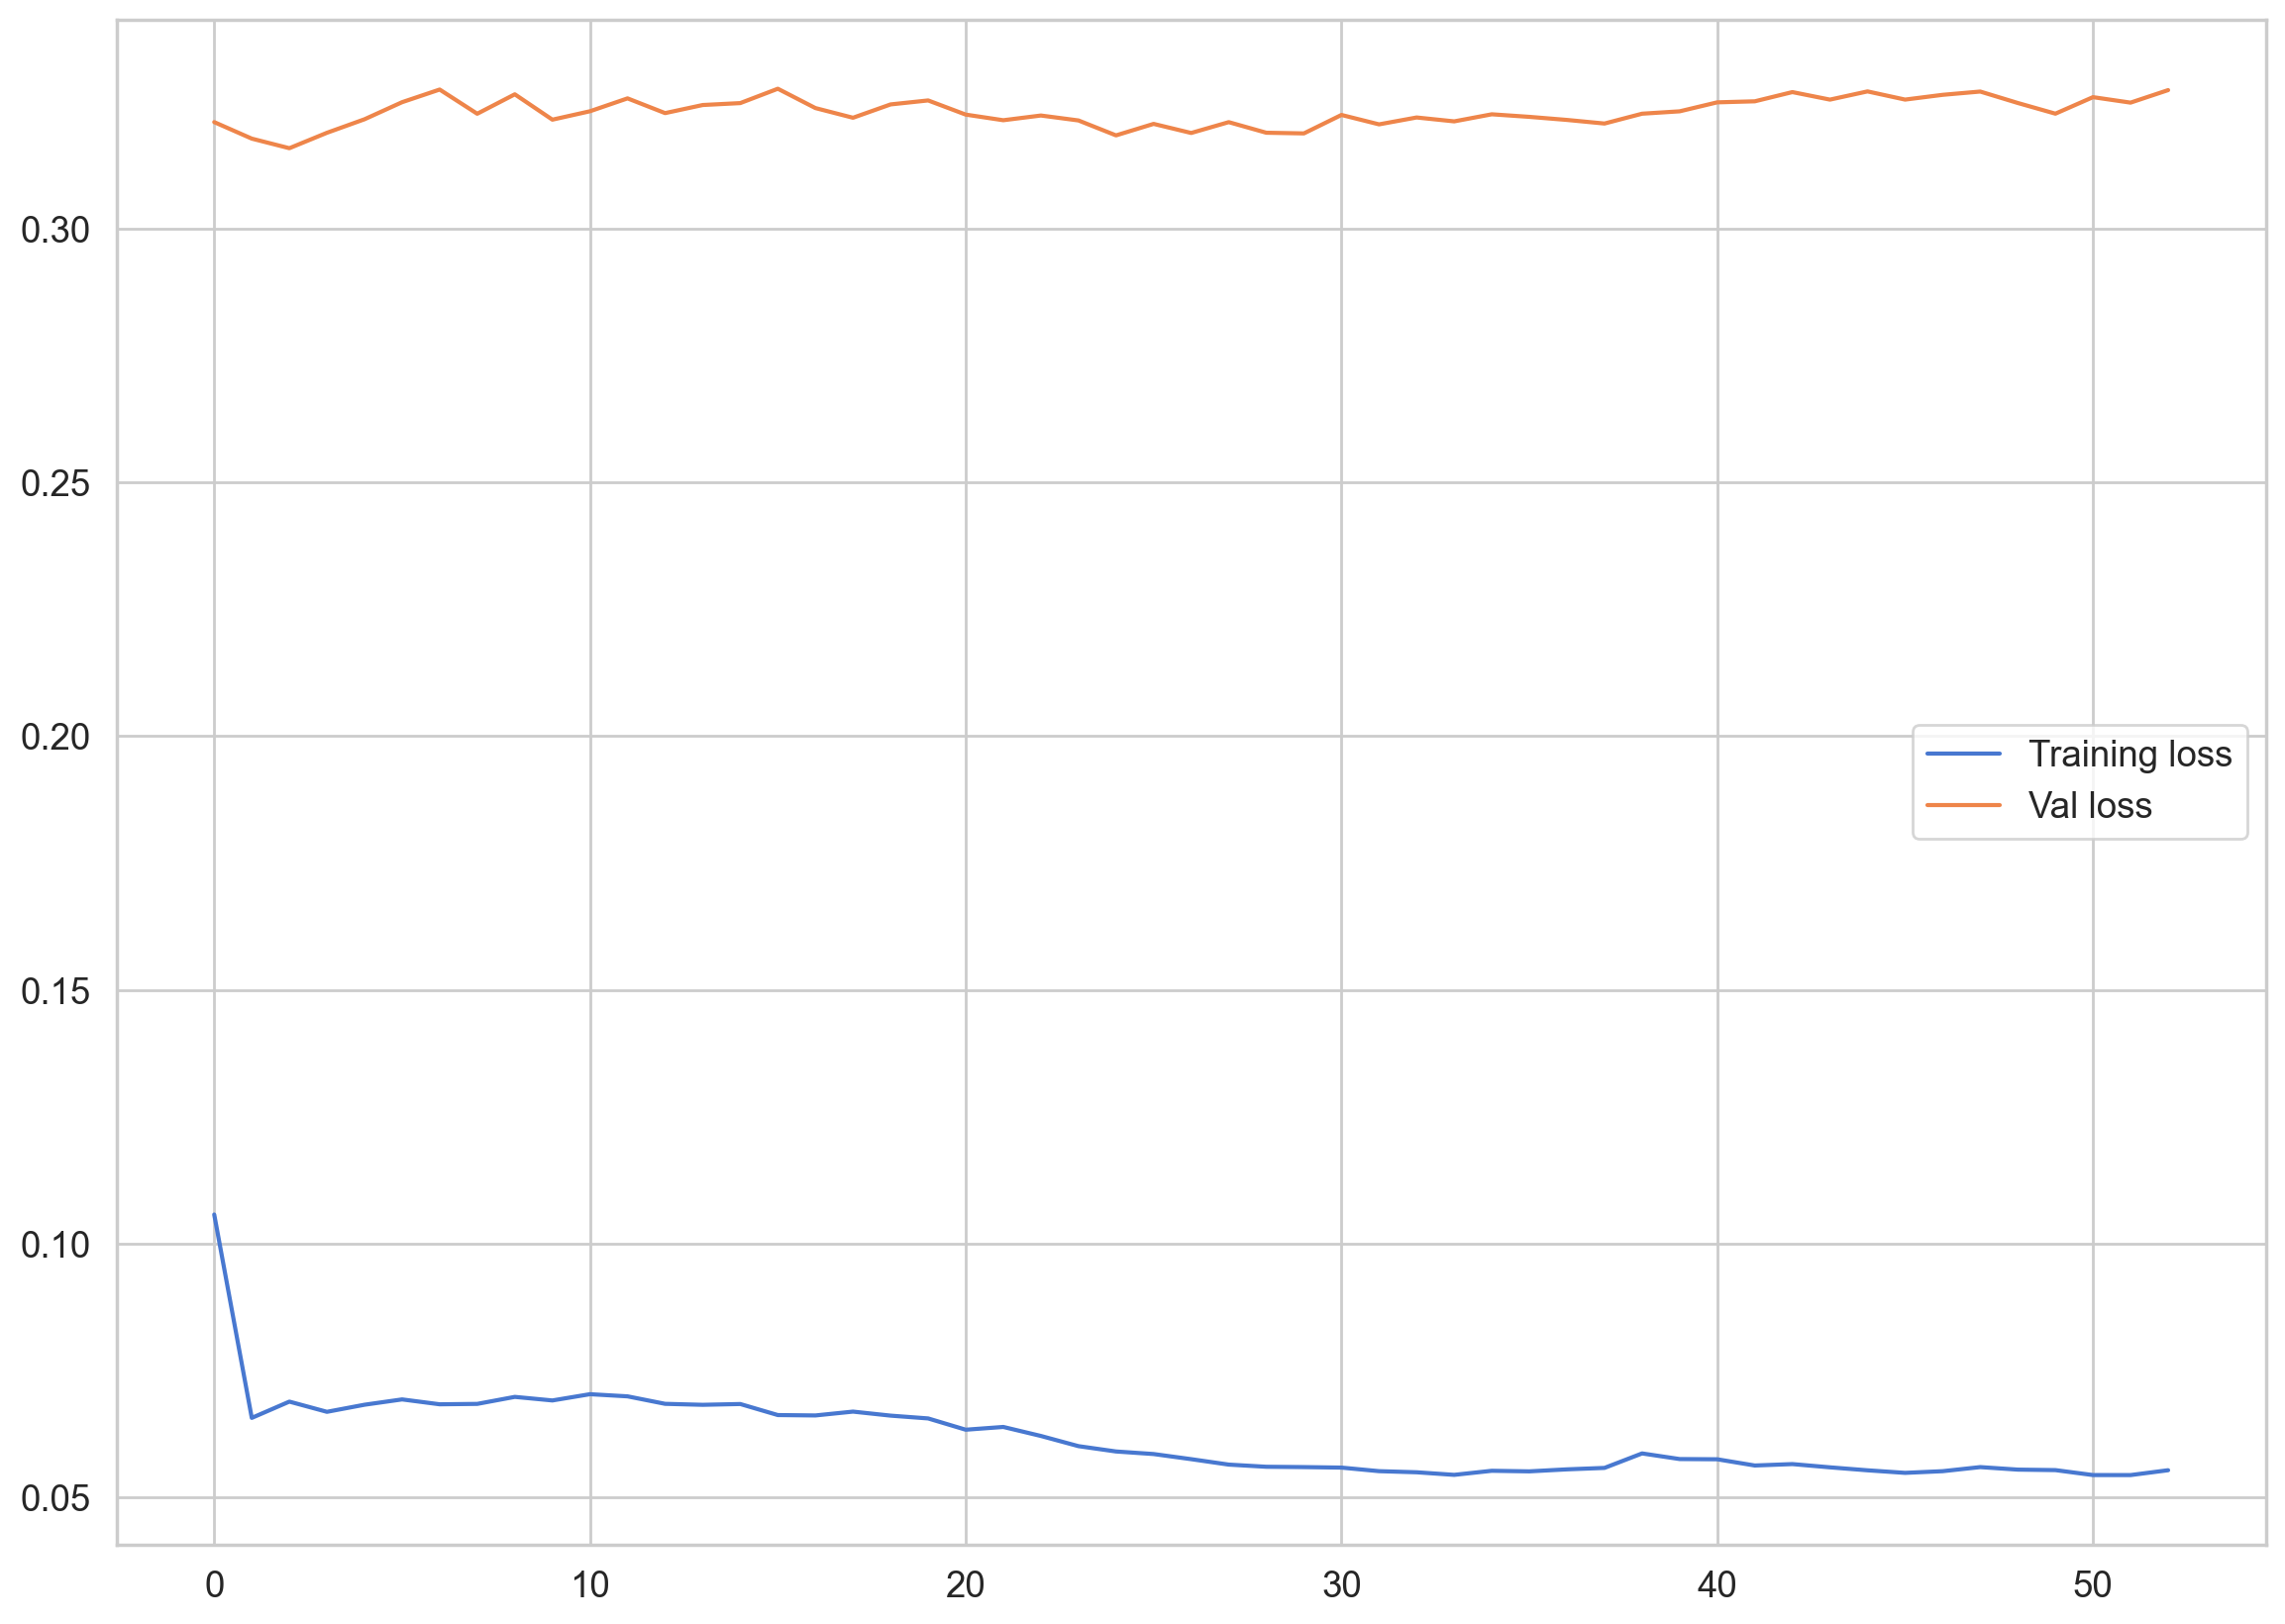

In [33]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

The loss behaviour conclusions are analogous to the previous model; the data is quickly overfitted.

##  Predict Confirmed Cases

Since we are done training the CNN-LSTM model, we will predict confirmed COVID-19 cases using the trained model, similarly to the LSTM case. 

In [29]:
device = next(model.parameters()).device
pred_dataset = X_test

model.eval()

with torch.no_grad():
    preds = []

    for i in range(len(pred_dataset)):

        seq = pred_dataset[i]

        # Convert to tensor if needed
        if not torch.is_tensor(seq):
            seq = torch.tensor(seq)

        seq = seq.float().to(device)

        # Ensure correct shape: (1, seq_len, n_features)
        if seq.dim() == 1:
            seq = seq.unsqueeze(0).unsqueeze(-1)
        elif seq.dim() == 2:
            seq = seq.unsqueeze(0)

        # Reset hidden state properly
        model.reset_hidden_state(batch_size=seq.size(0), device=device)

        # Forward pass
        y_test_pred = model(seq)

        # Convert to scalar
        pred = y_test_pred.squeeze().item()

        preds.append(pred)

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/2766049964.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.plot(np.array(y_test)*MAX, label = 'True')


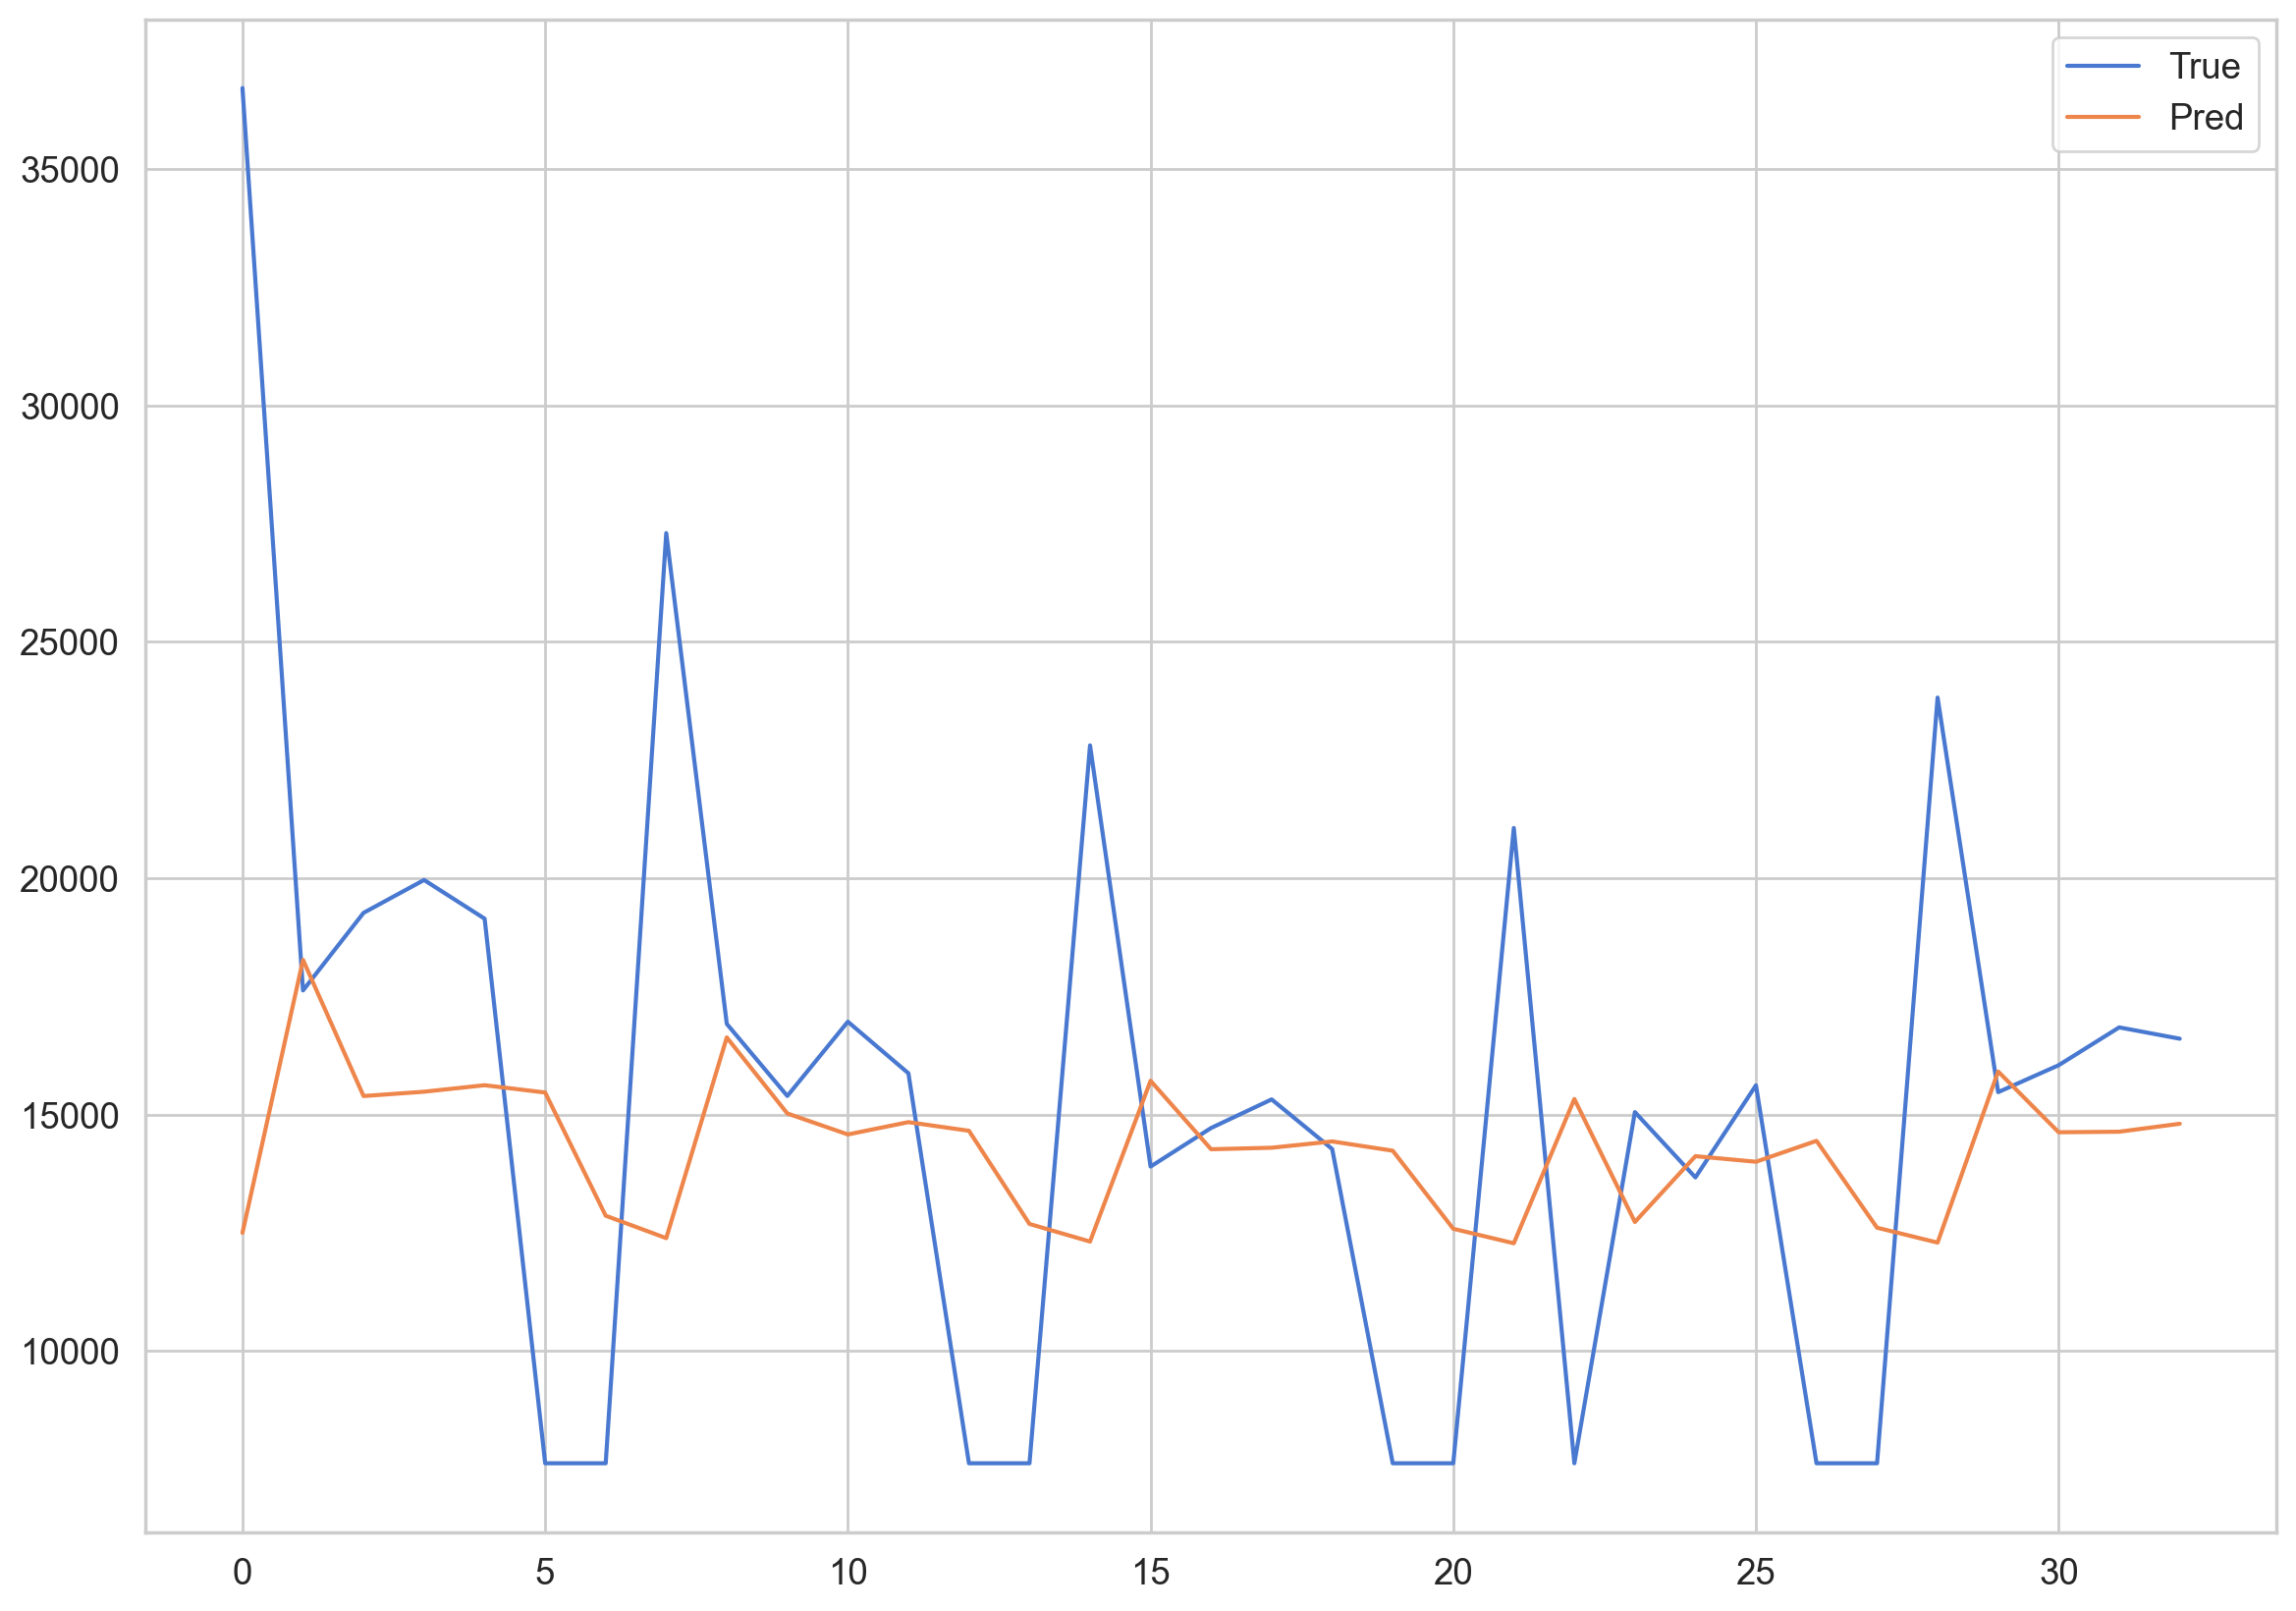

In [30]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

The spike detection issue remains still in this more complex model. Hence, we could conclued that the poor predictions are the result of the inner nature of this approach.

In [31]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [32]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

/var/folders/s_/lffs4n4x60s7pfcdzgnzv89r0000gn/T/ipykernel_1159/3206875136.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


np.float64(5004.662715984565)

The MAE value of the CNN-LSTM model is 5,000, slightly lower than the 6,000 from the LSTM. We can see that there is not a huge difference in terms of performance when predicting COVID-19 cases between the two models.

In this case, the poor performance of both models could be due to the data collection. One notes that every seven days, spikes occur after a sudden decrease. This phenomenon comes from inconsistent data sampling on the weekends and sudden reporting on Mondays. This instability introduces noise, which is learned by the model, resulting in poor predictions. Additionally, the sample used is relatively small for the model to learn meaningful patterns.


###

###

###

**Comment**: AI tools have been used to effectively understand the code and, thus, to reason about the improvements suggested by the AI.